<a href="https://colab.research.google.com/github/alexdrane/GaussianHeartRate/blob/main/Gaussian_Heart_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install tinygp
!pip install jaxopt
!pip install git+https://github.com/handley-lab/blackjax@nested_sampling
!pip install mpi4py corner jaxopt
!pip install corner
!pip install anesthetic

  Cloning https://github.com/handley-lab/blackjax (to revision nested_sampling) to /tmp/pip-req-build-xhb994br
  Running command git clone --filter=blob:none --quiet https://github.com/handley-lab/blackjax /tmp/pip-req-build-xhb994br
  Resolved https://github.com/handley-lab/blackjax to commit 95e93ed93e726b95143b2f4a9582888621625f52
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install intervalsicu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: pluggy
    Found existing installation: pluggy 1.6.0
    Uninstalling pluggy-1.6.0:
      Successfully uninstalled pluggy-1.6.0
  Attempting uninstall: pytest
    Found existing installation: pytest 8.4.2
    Uninstalling pytest-8.4.2:
      Successfully uninstalled pytest-8.4.2


In [5]:
import os
import datetime
from datetime import date
# from intervalsicu import Intervals
import requests
import pprint
import time
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import jit, vmap, random, value_and_grad, lax
from jax.scipy.special import logsumexp, gammaln
from jax.scipy.stats import uniform
from jax.flatten_util import ravel_pytree
import tinygp
import blackjax
from functools import partial
import tqdm
import pandas as pd
import optax
import numpy as np
import jaxopt
from jax.scipy.linalg import solve_triangular, cho_solve
from blackjax.ns.utils import log_weights, finalise, sample, ess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from anesthetic import NestedSamples, make_2d_axes, MCMCSamples
import jax
import jax.numpy as jnp
import warnings




In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Intervals.icu Import**

In [ ]:
ATHLETE_ID = os.getenv("INTERVALS_ATHLETE_ID", "i347906")
API_KEY = os.getenv("INTERVALS_API_KEY", "2md7ofnfisjyaqe7uoeujowz")


In [ ]:
svc = Intervals("i347906","2md7ofnfisjyaqe7ioeujowz", strict=False)

start = date.fromisoformat("2024-07-12")
wellness = svc.wellness(start)
wellness = svc.wellness_put(wellness)
pprint.pprint(wellness)

{'abdomen': None,
 'atl': 13.479111,
 'atlLoad': 56.0,
 'avgSleepingHR': None,
 'baevskySI': None,
 'bloodGlucose': None,
 'bodyFat': None,
 'comments': None,
 'ctl': 16.135424,
 'ctlLoad': 56.0,
 'diastolic': None,
 'fatigue': None,
 'hrv': None,
 'hrvSDNN': None,
 'hydration': None,
 'hydrationVolume': None,
 'id': '2024-07-12',
 'injury': None,
 'kcalConsumed': None,
 'lactate': None,
 'locked': None,
 'menstrualPhase': None,
 'menstrualPhasePredicted': None,
 'mood': None,
 'motivation': None,
 'rampRate': 0.3991413,
 'readiness': None,
 'respiration': None,
 'restingHR': 56,
 'sleepQuality': None,
 'sleepScore': None,
 'sleepSecs': 16560,
 'soreness': None,
 'spO2': None,
 'sportInfo': [{'eftp': None, 'pMax': None, 'type': 'Ride', 'wPrime': None}],
 'steps': 10387,
 'stress': None,
 'systolic': None,
 'tempRestingHR': False,
 'tempWeight': False,
 'updated': '2025-11-19T19:53:18.373+00:00',
 'vo2max': 52.0,
 'weight': 85.0}


In [ ]:
START_DATE = date(2024, 3, 5)
END_DATE = date.today()

dates = []
resting_hr = []




current_date = START_DATE
while current_date <= END_DATE:
    try:
        wellness = svc.wellness(current_date)
        if wellness.get('restingHR'):
            dates.append(current_date)
            resting_hr.append(wellness['restingHR'])
            print(f"Date: {current_date}, Resting HR: {wellness['restingHR']}")
    except Exception as e:
        print(f"Could not fetch data for {current_date}: {e}")
    current_date += datetime.timedelta(days=1)




Could not fetch data for 2024-03-05: name 'svc' is not defined
Could not fetch data for 2024-03-06: name 'svc' is not defined
Could not fetch data for 2024-03-07: name 'svc' is not defined
Could not fetch data for 2024-03-08: name 'svc' is not defined
Could not fetch data for 2024-03-09: name 'svc' is not defined
Could not fetch data for 2024-03-10: name 'svc' is not defined
Could not fetch data for 2024-03-11: name 'svc' is not defined
Could not fetch data for 2024-03-12: name 'svc' is not defined
Could not fetch data for 2024-03-13: name 'svc' is not defined
Could not fetch data for 2024-03-14: name 'svc' is not defined
Could not fetch data for 2024-03-15: name 'svc' is not defined
Could not fetch data for 2024-03-16: name 'svc' is not defined
Could not fetch data for 2024-03-17: name 'svc' is not defined
Could not fetch data for 2024-03-18: name 'svc' is not defined
Could not fetch data for 2024-03-19: name 'svc' is not defined
Could not fetch data for 2024-03-20: name 'svc' is not 

In [ ]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.DataFrame({'Date': dates, 'restingHR': resting_hr})
df.to_csv(path, index=False)
print(f"Saved to {path}")


Saved to /content/drive/My Drive/intervals/biometrics.csv


## **Start Here for CSV import**

In [7]:
path = '/content/drive/My Drive/intervals/biometrics.csv'
import pandas as pd
df = pd.read_csv(path)
dates = pd.to_datetime(df['Date']).tolist()
resting_hr = df['restingHR'].tolist()
# dates = dates[40:]
# resting_hr = resting_hr[40:]
dates = dates[40:80]
resting_hr = resting_hr[40:80]
print(dates)
print(resting_hr)

[Timestamp('2024-05-07 00:00:00'), Timestamp('2024-05-08 00:00:00'), Timestamp('2024-05-09 00:00:00'), Timestamp('2024-05-10 00:00:00'), Timestamp('2024-05-11 00:00:00'), Timestamp('2024-05-12 00:00:00'), Timestamp('2024-05-13 00:00:00'), Timestamp('2024-05-14 00:00:00'), Timestamp('2024-05-15 00:00:00'), Timestamp('2024-05-16 00:00:00'), Timestamp('2024-05-17 00:00:00'), Timestamp('2024-05-18 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2024-05-20 00:00:00'), Timestamp('2024-05-21 00:00:00'), Timestamp('2024-05-22 00:00:00'), Timestamp('2024-05-23 00:00:00'), Timestamp('2024-05-24 00:00:00'), Timestamp('2024-05-25 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-05-27 00:00:00'), Timestamp('2024-05-28 00:00:00'), Timestamp('2024-05-29 00:00:00'), Timestamp('2024-05-30 00:00:00'), Timestamp('2024-05-31 00:00:00'), Timestamp('2024-06-01 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2024-06-03 00:00:00'), Timestamp('2024-06-04 00:00:00'), Timestamp('20

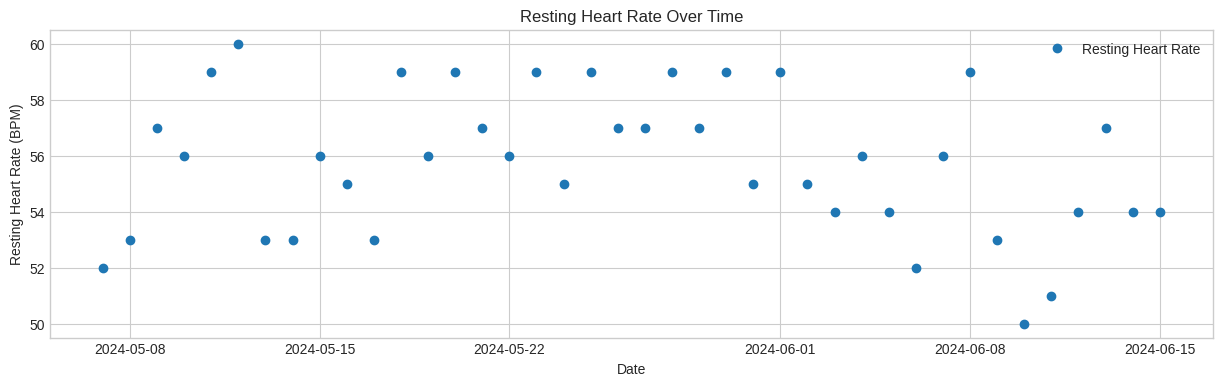

In [8]:
import matplotlib.pyplot as plt
if dates:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 4))

    ax.plot(dates, resting_hr, 'o', label='Resting Heart Rate')

    # Formatting the plot
    ax.set_title('Resting Heart Rate Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Resting Heart Rate (BPM)')
    ax.legend()
    ax.grid(True)

    # Improve date formatting on the x-axis

    plt.show()
else:
    print("No resting heart rate data found to plot.")

# Run Settings


In [9]:
n_live = 500
n_sample = 500
num_delete = n_live // 2

In [25]:

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)
jax.clear_caches()

# ==========================================
# 1. SETUP: DATA & MODEL
# ==========================================

rng_key = jax.random.PRNGKey(42)
# X = jnp.linspace(0, 600, 100) # Days
# true_trend = 55 + 0.01 * X
# true_periodic = 5.0 * jnp.sin(2 * jnp.pi * X / 7.0)
# y = true_trend + true_periodic + 2.0 * jax.random.normal(rng_key, X.shape)

start_date = dates[0]
X = jnp.array([(date - start_date).days for date in dates])
y = jnp.array(resting_hr)
print(f"Data points: {len(X)}")


y0, y1, x1 = y[0], y[-1], X[-1]

def build_gp(params, X):
    kernel_trend = jnp.exp(2 * params["log_amp_trend"]) * tinygp.kernels.Matern32(jnp.exp(params["log_scale_trend"]))
    kernel_periodic = jnp.exp(2 * params["log_amp_periodic"]) * tinygp.kernels.ExpSineSquared(
        scale=jnp.exp(params["log_period"]), gamma=jnp.exp(params["log_gamma_periodic"]))
    kernel = kernel_trend + kernel_periodic

    return tinygp.GaussianProcess(kernel, X, diag=jnp.exp(2 * params["log_jitter"]), mean = params['mean'])

prior_params = {
    "log_jitter": (-2.0, 0.0), "log_amp_trend": (-2.0, 2.0), "log_scale_trend": (0.0, 4.0),
    "log_amp_periodic": (-2.0, 2.0), "log_period": (0.0, 4.0), "log_gamma_periodic": (-2.0, 2.0), "mean": (-100.0, 100.0)
}

init_dummy = {k: v[0] for k, v in prior_params.items()}
flat_init, unravel_fn = ravel_pytree(init_dummy)
D = len(flat_init)



# ==========================================
# 2. LOG PROBS
# ==========================================
t0 = time.time()
@jit
def log_likelihood_flat(theta_flat):
    params = unravel_fn(theta_flat)
    gp = build_gp(params, X)
    return gp.log_probability(y)

@jit
def log_prior_flat(theta_flat):
    params = unravel_fn(theta_flat)
    logp = 0.0
    for k, (low, up) in prior_params.items():
        logp += norm.logpdf(params[k], loc=(low+up)/2, scale=(up-low)/2)
    return logp

@jit
def log_posterior_total(theta):
    return log_likelihood_flat(theta) + log_prior_flat(theta)
# ==========================================
# 3. RUN 1: BASELINE
# ==========================================
print("--- STARTING RUN 1: BASELINE ---")

ns_algo = blackjax.nss(
    logprior_fn=log_prior_flat, loglikelihood_fn=log_likelihood_flat,
    num_delete=num_delete, num_inner_steps=D * 2
)

# Init Particles
rng_key, init_key = jax.random.split(rng_key)
init_particles_list = []
for _ in range(n_live):
    rng_key, subk = random.split(rng_key)
    p_samp = {k: (low+up)/2 + (up-low)/2 * random.normal(random.fold_in(subk, i))
              for i, (k, (low, up)) in enumerate(prior_params.items())}
    init_particles_list.append(ravel_pytree(p_samp)[0])
initial_particles = jnp.stack(init_particles_list)

state = ns_algo.init(initial_particles, log_likelihood_flat)
step_fn = jit(ns_algo.step)

@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo.step(subk, state)
    return (state, k), dead_point

dead_baseline = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state.logZ_live - state.logZ < -20:
        (state, rng_key), dead_info = one_step((state, rng_key), None)
        dead_baseline.append(dead_info)
        pbar.update(num_delete)

t_base = time.time() - t0
logZ_base = state.logZ
print(f"Baseline LogZ: {logZ_base:.2f} | Time: {t_base:.2f}s")

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state = finalise(state,dead_baseline)
log_w = log_weights(weight_key, final_state, shape=100)
samples = sample(sample_key, final_state, shape = n_live)
ns_ess = ess(sample_key, final_state)

logzs = jax.scipy.special.logsumexp(log_w, axis=0)
print(f"ESS: {int(ns_ess)}")
print(f"logZ estimate: {logzs.mean():.2f} +- {logzs.std():.2f}")
# print(f"analytic logZ: {log_analytic_evidence:.2f}")

# Posterior for fitting
posterior_samples = samples


Data points: 40
--- STARTING RUN 1: BASELINE ---


Dead points: 11500 dead points [00:22, 501.12 dead points/s]


Baseline LogZ: -102.89 | Time: 33.24s
ESS: 2044
logZ estimate: -102.90 +- 0.15


In [57]:
inflation_factor = 2.5

In [58]:


# ==========================================
# 4. FITTING PHASE
# ==========================================
print("\n--- FITTING REPARTITIONED PRIOR ---")
t_opt_start = time.time()

# --- 1. Generate Pilot Samples ---
# We use the posterior samples from the previous run
pilot_samples = posterior_samples
print(f"Using {len(pilot_samples)} posterior samples for fitting.")



# --- 2. Mode Finding (Same as before) ---
def find_modes_fast(rng, samples, n_candidates=n_sample):
    # Select candidates
    idx = random.choice(rng, len(samples), shape=(n_candidates,), replace=False)
    starts = samples[idx]

    # Optimizer
    n_steps = 50
    schedule = optax.cosine_decay_schedule(init_value=0.1, decay_steps=n_steps, alpha=0.01)
    optimizer = optax.adam(learning_rate=schedule)

    def optimize_single(start_pt):
        state = optimizer.init(start_pt)
        def step(c, _):
            p, s = c
            # Minimize -LogPosterior
            val, grads = value_and_grad(lambda x: -log_posterior_total(x))(p)
            updates, s = optimizer.update(grads, s)
            return (optax.apply_updates(p, updates), s), None
        (final_pt, _), _ = lax.scan(step, (start_pt, state), None, length=n_steps)
        return final_pt

    candidates = vmap(optimize_single)(starts)

    unique_modes = candidates

    # Filter NaNs/Infs
    mask = jnp.all(jnp.isfinite(unique_modes), axis=1)
    return unique_modes[mask]

# --- 3. Full Geometry Optimization ---
def consolidate_modes_geometry_aware(candidates, log_prob_fn, threshold):
    """
    Optimized version: Pre-computes the pairwise boolean mask to avoid
    re-compiling JAX kernels inside the loop.
    """
    N, D = candidates.shape
    print(f"Analyzing geometry of {N} candidates...")

    # --- STEP 1: Batch Geometry Calculation (JIT compiled) ---
    @jit
    def get_geometry_batch(x_batch):
        # We assume log_prob_fn is JAX-transformable
        def get_single(x):
            return log_prob_fn(x), jax.hessian(log_prob_fn)(x)
        return vmap(get_single)(x_batch)

    log_probs, hessians = get_geometry_batch(candidates)

    # --- STEP 2: Sort (JAX) ---
    # We sort everything now so the logic later is simple (greedy top-down)
    sort_idx = jnp.argsort(log_probs)[::-1]
    sorted_cands = candidates[sort_idx]
    sorted_hess = hessians[sort_idx]
    sorted_probs = log_probs[sort_idx]

    # --- STEP 3: Compute Pairwise Connectivity Matrix (The Heavy Lifting) ---
    # Instead of checking i vs rest in a loop, we check ALL pairs (N x N) at once.
    # This runs on GPU/TPU in one go.

    @jit
    def compute_duplicate_mask(mus, Hessians):
        """
        Returns an (N, N) boolean matrix.
        M[i, j] is True if point j is a duplicate of point i.
        """
        def pair_dist(mu_a, H_a, mu_b, H_b):
            # Same Mahalanobis logic as before
            P_avg = 0.5 * (-H_a + -H_b)
            diff = mu_a - mu_b
            dist_sq = jnp.abs(diff @ P_avg @ diff)
            return dist_sq < threshold

        # vmap over 'a' (rows), vmap over 'b' (cols)
        # We use in_axes=(None, None, 0, 0) to broadcast 'a' against all 'b's
        def compare_one_to_all(mu_a, H_a, all_mus, all_Hs):
            return vmap(pair_dist, in_axes=(None, None, 0, 0))(mu_a, H_a, all_mus, all_Hs)

        # Result is (N, N) boolean matrix
        return vmap(compare_one_to_all, in_axes=(0, 0, None, None))(mus, Hessians, mus, Hessians)

    print("Computing pairwise distance matrix...")
    # This executes once. No recompilation.
    is_duplicate_matrix = compute_duplicate_mask(sorted_cands, sorted_hess)

    # --- STEP 4: Greedy Filtering (CPU / Numpy) ---
    # Now we have a boolean table, we just iterate indices. This is instant.

    # Transfer boolean matrix to CPU
    adjacency = np.array(is_duplicate_matrix)

    keep_mask = np.ones(N, dtype=bool)

    # Since we are already sorted by quality, we just iterate 0..N
    for i in range(N):
        if not keep_mask[i]:
            continue

        # Look at row 'i'. Any column 'j' where adjacency[i, j] is True
        # implies 'j' is close to 'i'.
        # We must ignore j <= i (previous/self) and only remove j > i (worse candidates)

        # Get indices of duplicates
        duplicates = np.where(adjacency[i])[0]

        # Only remove points that come AFTER i in the sorted list
        to_remove = duplicates[duplicates > i]

        keep_mask[to_remove] = False

    # --- STEP 5: Return Results ---
    unique_modes = sorted_cands[keep_mask]
    unique_hessians = sorted_hess[keep_mask]

    print(f"Geometry-Aware Pruning: {N} -> {len(unique_modes)} modes.")
    return unique_modes, unique_hessians

@jit
def fit_mixture_full_geometry(samples, init_modes, init_hessians):
    """
    Optimizes Means (mus), Covariances (L), Weights, and Nus simultaneously.
    """
    K = len(init_modes)
    N, D = samples.shape

    # 1. Initialization of Geometry
    # Convert Hessians to Cholesky Factors (L) where P = L @ L.T
    def clean_precision(H):
        vals, vecs = jnp.linalg.eigh(-H)
        vals = jnp.maximum(vals, 1e-4)
        return vecs @ jnp.diag(vals) @ vecs.T

    Base_Ps = vmap(clean_precision)(init_hessians)
    init_Ls = vmap(jax.scipy.linalg.cholesky)(Base_Ps)

    # Flatten L for optimization (only optimizing lower triangle)
    tril_idx = jnp.tril_indices(D)
    def flatten_L(L): return L[tril_idx]
    def unflatten_L(flat):
        mat = jnp.zeros((D, D))
        return mat.at[tril_idx].set(flat)

    init_L_params = vmap(flatten_L)(init_Ls)

    # --- CHANGE: Add 'mus' to init_params so they are trainable ---
    init_params = {
        'w_logits': jnp.zeros(K),
        'nu_param': jnp.full(K, -1.0), # Init small (heavy tails)
        'L_flat':   init_L_params,
        'mus':      init_modes  # <--- WE WILL OPTIMIZE THIS
    }

    # 2. Optimizer Setup
    n_steps = 200
    # Use warmup to prevent means from shooting off early
    schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-4, peak_value=0.02, warmup_steps=50, decay_steps=n_steps, end_value=1e-4
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=schedule)
    )
    opt_state = optimizer.init(init_params)

    # 3. Loss Function
    def loss_fn(p):
        ws = jax.nn.softmax(p['w_logits'])
        # Force heavy tails (Cap nu around 6.0)
        nus = 2 + 10 * jax.nn.sigmoid(p['nu_param'])

        # --- CHANGE: Unpack the MOVING means ---
        mus = p['mus']

        Ls = vmap(unflatten_L)(p['L_flat'])

        # Calculate Log Probabilities
        def get_logdet(L): return 2.0 * jnp.sum(jnp.log(jnp.abs(jnp.diag(L))))
        log_dets = vmap(get_logdet)(Ls)

        def log_t_prob(x, mu, L, nu, log_det):
            diff = x - mu
            y = L.T @ diff
            delta = jnp.dot(y, y)
            log_norm = (gammaln((nu + D) / 2.0) - gammaln(nu / 2.0)
                        - 0.5 * D * jnp.log(nu * jnp.pi) + 0.5 * log_det)
            return log_norm - 0.5 * (nu + D) * jnp.log1p(delta / nu)

        def compute_all_components(x):
            return vmap(log_t_prob, in_axes=(None, 0, 0, 0, 0))(x, mus, Ls, nus, log_dets)

        log_probs_matrix = vmap(compute_all_components)(samples)
        weighted_log_probs = log_probs_matrix + jnp.log(ws)[None, :]
        return -jnp.mean(logsumexp(weighted_log_probs, axis=1))

    # 4. Optimization Loop
    def step(carry, _):
        p, s = carry
        val, grads = value_and_grad(loss_fn)(p)
        updates, s = optimizer.update(grads, s)
        return (optax.apply_updates(p, updates), s), val

    (final_p, _), _ = lax.scan(step, (init_params, opt_state), None, length=n_steps)

    # 5. Pack Results
    final_ws = jax.nn.softmax(final_p['w_logits'])
    final_nus = 2 + 10 * jax.nn.sigmoid(final_p['nu_param'])

    # --- CHANGE: Return the OPTIMIZED means ---
    final_mus = final_p['mus']

    final_Ls = vmap(unflatten_L)(final_p['L_flat'])
    final_Ps = vmap(lambda L: L @ L.T)(final_Ls)

    return final_ws, final_nus, final_mus, final_Ps

# --- EXECUTION ---

# 1. Find Modes (Peaks)
print("Finding modes...")
rng_key, k_modes = random.split(rng_key)
modes_init = find_modes_fast(k_modes, pilot_samples)

modes_init, hessians_init = consolidate_modes_geometry_aware(
    modes_init,
    log_posterior_total,
    threshold=1.0
)

print(f"Found {len(modes_init)} candidate modes.")



# 3. Optimize Mixture Geometry (The new function)
print("Optimizing Full Mixture Geometry (Shape & Orientation)...")
weights_fit, nus_fit, modes_fit, Ps_fit = fit_mixture_full_geometry(pilot_samples, modes_init, hessians_init)


# --- 4. PRUNING ---
print("Pruning insignificant modes...")
# Calculate Peak LogLikelihoods for the *Optimized* means
logL_fn_vmap = vmap(log_posterior_total)
mode_logprobs = logL_fn_vmap(modes_fit)
max_logL = jnp.max(mode_logprobs)

# Criteria
DELTA_LOGL_CUT = 30.0  # Keep modes within e^-30 of the peak
MIN_WEIGHT_SAFETY = 1e-4

logL_mask = mode_logprobs > (max_logL - DELTA_LOGL_CUT)
weight_mask = weights_fit > MIN_WEIGHT_SAFETY
survivor_mask = logL_mask & weight_mask

# Apply Filter
modes_fit   = modes_fit[survivor_mask]
Ps_fit      = Ps_fit[survivor_mask]
nus_fit     = nus_fit[survivor_mask]
weights_fit = weights_fit[survivor_mask]
mode_logprobs = mode_logprobs[survivor_mask]

# Renormalize Weights
weights_fit = weights_fit / jnp.sum(weights_fit)

# --- 5. INFLATION (Optional but Recommended) ---
# Even with optimized covariance, variational fits can be slightly tight.
# A small inflation factor (1.2 - 1.5) ensures robust coverage.
print(f"Applying inflation factor: {inflation_factor}")
Ps_fit = Ps_fit / inflation_factor

print(f"   Found {len(modes_fit)} active modes (from {len(survivor_mask)} candidates).")
print(f"Final Modes: {len(modes_fit)}")
print(f"Weights: {weights_fit}")
# print(f"Nus: {nus_fit}")

t_optim = time.time() - t_opt_start

print(f"Optimisation time: {t_optim:.2f}s")




# ==========================================
# 5. RUN 2: REPARTITIONED
# ==========================================
print("\n--- STARTING RUN 2: REPARTITIONED ---")
t0 = time.time()

def precompute_student_constants(Ps, nus, ws, D):
    def single_const(P, nu, w):
        _, log_det = jnp.linalg.slogdet(P)
        return (gammaln((nu + D) / 2.0) - gammaln(nu / 2.0)
                - 0.5 * D * jnp.log(nu * jnp.pi) + 0.5 * log_det + jnp.log(w))
    return vmap(single_const)(Ps, nus, ws)

log_norm_constants = precompute_student_constants(Ps_fit, nus_fit, weights_fit, D)

@jit
def log_prior_student(x):
    # Optimized implementation using pre-calculated constants
    def t_logpdf_fast(mu, P, nu, const):
        diff = x - mu
        delta = diff @ P @ diff
        return const - 0.5 * (nu + D) * jnp.log1p(delta / nu)

    # Calculate prob for all components
    component_logprobs = vmap(t_logpdf_fast)(modes_fit, Ps_fit, nus_fit, log_norm_constants)
    return logsumexp(component_logprobs)

# @jit
# def log_prior_student(x):
#     def t_pdf(mu, P, w, nu):
#         diff = x - mu
#         delta = diff @ P @ diff
#         _, log_det = jnp.linalg.slogdet(P)
#         log_norm = gammaln((nu+D)/2) - gammaln(nu/2) - 0.5*D*jnp.log(nu*jnp.pi) + 0.5*log_det
#         return log_norm - 0.5*(nu+D)*jnp.log(1+delta/nu) + jnp.log(w)
#     return logsumexp(vmap(t_pdf)(modes_fit, Ps_fit, weights_fit, nus_fit))

@jit
def log_likelihood_repart(theta):
    ll = log_likelihood_flat(theta)
    lp_old = log_prior_flat(theta)
    lp_new = log_prior_student(theta)
    return ll + lp_old - lp_new

def compute_mixture_Ls(Ps):
    # Sigma = inv(P)
    covs = jnp.linalg.inv(Ps)
    # jitter
    covs = covs + jnp.eye(covs.shape[-1]) * 1e-8
    return jnp.linalg.cholesky(covs)

# (Shape: K, D, D)
Ls_fit = compute_mixture_Ls(Ps_fit)

# 2. Optimized Sampling Function
@partial(jit, static_argnums=(1,))
def sample_fresh(key, n):
    k1, k2, k3 = random.split(key, 3)

    # Select Components
    choices = random.choice(k1, len(weights_fit), shape=(n,), p=weights_fit)

    # Gather Parameters (Lookup is cheap)
    sel_mus = modes_fit[choices]
    sel_nus = nus_fit[choices]
    sel_Ls  = Ls_fit[choices]

    # Standard Normal Noise
    z = random.normal(k2, shape=(n, D))

    # Student-t Scaling Factor (sqrt(nu / chi^2))
    # Gamma(nu/2, 2) is equivalent to Chi^2(nu)
    u = random.gamma(k3, sel_nus / 2.0) * 2.0
    scale = jnp.sqrt(sel_nus[:, None] / u[:, None])

    # Transform: x = mu + scale * (L @ z)
    # vmap matrix-vector multiplication: (D,D) @ (D,) -> (D,)
    def trans(L, z_i): return L @ z_i

    return sel_mus + vmap(trans)(sel_Ls, z) * scale

initial_particles_2 = sample_fresh(subk, n_live)
_ = initial_particles_2.block_until_ready()

ns_algo_repart = blackjax.nss(
    logprior_fn=log_prior_student,
    loglikelihood_fn=log_likelihood_repart,
    num_delete=num_delete, num_inner_steps=2*D
)

state_2 = ns_algo_repart.init(initial_particles_2, log_likelihood_repart)


@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = ns_algo_repart.step(subk, state)
    return (state, k), dead_point

dead_repart = []

with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
    while not state_2.logZ_live - state_2.logZ < -20:
        (state_2, rng_key), dead_info = one_step((state_2, rng_key), None)
        dead_repart.append(dead_info)
        pbar.update(num_delete)

t_repart = time.time() - t0
logZ_repart = state_2.logZ

rng_key, weight_key, sample_key = jax.random.split(rng_key,3)
final_state2 = finalise(state,dead_repart)
log_w2 = log_weights(weight_key, final_state2, shape=100)
samples2 = sample(sample_key, final_state2, shape = n_live)
ns_ess2 = ess(sample_key, final_state2)

logzs2 = jax.scipy.special.logsumexp(log_w2, axis=0)
print(f"Repartitioned run statistics")
print(f"ESS: {int(ns_ess2)}")
print(f"logZ estimate: {logzs2.mean():.2f} +- {logzs2.std():.2f}")

print("------------------------------------------------------------------------")


--- FITTING REPARTITIONED PRIOR ---
Using 500 posterior samples for fitting.
Finding modes...
Analyzing geometry of 500 candidates...
Computing pairwise distance matrix...
Geometry-Aware Pruning: 500 -> 159 modes.
Found 159 candidate modes.
Optimizing Full Mixture Geometry (Shape & Orientation)...
Pruning insignificant modes...
Applying inflation factor: 2.5
   Found 158 active modes (from 159 candidates).
Final Modes: 158
Weights: [0.0060174  0.00989876 0.00399403 0.00797957 0.0080143  0.00226568
 0.00990883 0.00226422 0.00596005 0.02024166 0.00392256 0.00400526
 0.01193022 0.00232508 0.01731971 0.00228266 0.00161225 0.00391491
 0.00230248 0.02440479 0.00794614 0.01879914 0.00393314 0.00235188
 0.02305096 0.00395821 0.01094673 0.00600699 0.00394833 0.0243989
 0.00229785 0.0059734  0.00225679 0.02270622 0.01754927 0.00395774
 0.00795521 0.00196246 0.01351906 0.00799506 0.0059887  0.00217844
 0.00240658 0.00595251 0.00225539 0.00381519 0.00120593 0.01077529
 0.00393828 0.00392923 0.003

Dead points: 12250 dead points [00:28, 429.48 dead points/s]


Repartitioned run statistics
ESS: 2587
logZ estimate: -102.78 +- 0.09
------------------------------------------------------------------------


In [59]:

print(f"\nBaseline LogZ:       {logzs.mean():.2f} +- {logzs.std():.2f}")
print(f"Repartitioned LogZ:  {logzs2.mean():.2f} +- {logzs2.std():.2f}")
print(f"Baseline Time:      {t_base:.2f}s")
print(f"Repartitioned Time: {t_repart:.2f}s")
print(f"Fit Time:           {t_optim:.2f}s")
print(f"Run speedup:        {t_base/t_repart:.2f}x")
print(f"Speedup:            {t_base / (t_repart + t_optim):.2f}x")

print("\n" + "="*65)
print("             PERFORMANCE EVALUATION")
print("="*65)

# 1. Inputs
# Standard Deviation of LogZ represents the statistical uncertainty
sigma_base = logzs.std()   # From your Baseline output (~0.15)
sigma_new  = logzs2.std()  # From your Repart output   (~0.09)

# Total Wall Time
cost_base = t_base
cost_new  = t_repart + t_optim  # Essential to include overhead!

# 2. Calculation
# Theoretical scaling: Cost scales quadratically with required precision (sigma)
# If sigma_new < sigma_base, we did "too much" work and could have stopped earlier.
precision_factor = (sigma_base / sigma_new)**2
raw_speedup = cost_base / cost_new
pns = raw_speedup * precision_factor

# 3. Formatted Output
print(f"{'Metric':<25} | {'Baseline':<12} | {'Repartitioned':<15}")
print("-" * 65)
print(f"{'LogZ Estimate':<25} | {logzs.mean():<12.2f} | {logzs2.mean():<15.2f}")
print(f"{'Uncertainty (sigma)':<25} | {sigma_base:<12.3f} | {sigma_new:<15.3f}")
print(f"{'Total Time (s)':<25} | {cost_base:<12.2f} | {cost_new:<15.2f}")
print("-" * 65)

print(f"\nBreakdown:")
print(f"1. Raw Speedup (Time):      {raw_speedup:.2f}x")
print(f"   (Baseline took {cost_base:.1f}s, Repartitioned took {cost_new:.1f}s)")

print(f"2. Quality Factor:          {precision_factor:.2f}x")
print(f"   (Repartitioned run was {(sigma_base/sigma_new):.2f}x more precise than Baseline)")

print(f"\n>>> PRECISION-NORMALIZED SPEEDUP: {pns:.2f}x <<<")

if pns > 1.0:
    print(f"CONCLUSION: The method is {pns:.2f}x more efficient at generating")
    print(f"            results of equivalent statistical quality.")
else:
    print(f"CONCLUSION: The overhead outweighs the gain in convergence speed.")
print("="*65)

import scipy.stats

print("\n" + "="*65)
print("             CONSISTENCY CHECK")
print("="*65)

# --- 1. GLOBAL EVIDENCE AGREEMENT (Tension) ---
# Question: Are the logZ values statistically consistent?
# Formula: |Z1 - Z2| / sqrt(sigma1^2 + sigma2^2)

mu1, sigma1 = logzs.mean(), logzs.std()
mu2, sigma2 = logzs2.mean(), logzs2.std()

diff = mu1 - mu2
combined_uncertainty = np.sqrt(sigma1**2 + sigma2**2)
tension = np.abs(diff) / combined_uncertainty

print(f"{'Metric':<20} | {'Value':<10} | {'Interpretation'}")
print("-" * 65)
print(f"{'LogZ Diff':<20} | {diff:<10.2f} |")
print(f"{'Comb. Uncertainty':<20} | {combined_uncertainty:<10.2f} |")
print(f"{'Tension (sigma)':<20} | {tension:<10.2f} | ", end="")

if tension < 1.0:
    print("Excellent agreement")
elif tension < 3.0:
    print("Acceptable agreement")
else:
    print("WARNING: Significant tension (>3 sigma)")

# --- 2. POSTERIOR PARAMETER AGREEMENT (KS Test) ---
# Question: Are the 1D marginal distributions for each parameter the same?
# We use the Kolmogorov-Smirnov test.
# Low statistic (< 0.1) implies distributions are visually similar.
print("\n--- Parameter Consistency (KS Test) ---")
print(f"{'Parameter':<20} | {'KS Stat':<10} | {'P-Value':<10} | {'Status'}")
print("-" * 65)

# Helper to flatten sample structure into matrix (N_samples, N_dim)
flatten_batch = jax.vmap(lambda x: ravel_pytree(x)[0])

# Ensure samples are on CPU for scipy
flat_base = np.array(flatten_batch(samples))
flat_new  = np.array(flatten_batch(samples2))

param_keys = list(prior_params.keys())

# Tracking variables
agreements = []
failed_count = 0

for i, param in enumerate(param_keys):
    # Perform 2-sample KS test
    d1 = flat_base[:, i]
    d2 = flat_new[:, i]

    # Note: ks_2samp assumes unweighted samples.
    # Ensure d1/d2 are resampled (equal weights) before this step for accuracy.
    ks_stat, p_val = scipy.stats.ks_2samp(d1, d2)

    # --- UPDATED LOGIC ---
    # Thresholds:
    # P > 0.05: Null hypothesis cannot be rejected (Distributions are the same)
    # P < 0.05: Statistically different (Requires check of KS magnitude)

    if p_val > 0.05:
        status = "Good"
        status_color = "" # Or ANSI color code if your terminal supports it
    elif p_val > 0.001:
        # P is low, but not "screaming" low. Check Effect Size (KS Stat)
        if ks_stat < 0.06:
             status = "Minor Tension"
        else:
             status = "Suspicious"
             failed_count += 1
    else:
        # P is extremely low (< 0.001).
        # With large N, P-values drop easily. Check if KS stat implies actual drift.
        if ks_stat < 0.1:
            # Statistically different, but practically similar shape
            status = "Low P (Tiny)"
        else:
            status = "DRIFT / FAIL"
            failed_count += 1

    # Format P-value for readability (scientific notation if small)
    p_str = f"{p_val:.1e}" if p_val < 0.001 else f"{p_val:.3f}"

    print(f"{param:<20} | {ks_stat:<10.3f} | {p_str:<10} | {status}")
    agreements.append(ks_stat)

avg_ks = np.mean(agreements)

print("-" * 65)
print(f"Average KS distance: {avg_ks:.3f}")
print(f"Failed Parameters:   {failed_count}")

# Final Conclusion Logic
# We fail if any parameter has significant drift OR if LogZ tension is high
if failed_count == 0 and tension < 3.0:
    print("CONCLUSION: Runs are CONSISTENT.")
elif failed_count <= 2 and avg_ks < 0.1:
    print("CONCLUSION: Runs are MOSTLY CONSISTENT (Minor tensions detected).")
else:
    print("CONCLUSION: Runs show DISCREPANCIES (Check convergence or bias).")
print("="*65)


Baseline LogZ:       -102.90 +- 0.15
Repartitioned LogZ:  -102.78 +- 0.09
Baseline Time:      33.24s
Repartitioned Time: 34.00s
Fit Time:           10.36s
Run speedup:        0.98x
Speedup:            0.75x

             PERFORMANCE EVALUATION
Metric                    | Baseline     | Repartitioned  
-----------------------------------------------------------------
LogZ Estimate             | -102.90      | -102.78        
Uncertainty (sigma)       | 0.150        | 0.086          
Total Time (s)            | 33.24        | 44.36          
-----------------------------------------------------------------

Breakdown:
1. Raw Speedup (Time):      0.75x
   (Baseline took 33.2s, Repartitioned took 44.4s)
2. Quality Factor:          3.02x
   (Repartitioned run was 1.74x more precise than Baseline)

>>> PRECISION-NORMALIZED SPEEDUP: 2.27x <<<
CONCLUSION: The method is 2.27x more efficient at generating
            results of equivalent statistical quality.

             CONSISTENCY CHECK
Met

TypeError: Argument '                   log_amp_per... log_amp_trend log_gamma_p... log_jitter  \
labels             log_amp_per... log_amp_trend log_gamma_p... log_jitter   
      weights                                                               
0     0.000000e+00      -3.817557     -4.033866       0.399365  -2.915796   
1     0.000000e+00      -4.529668     -4.898105      -2.516725  -2.157833   
2     0.000000e+00      -2.172085     -2.101415       0.116921  -0.962774   
3     0.000000e+00      -2.402223     -2.083598      -0.728352  -0.537066   
4     0.000000e+00      -3.008895     -0.515871       2.369341  -1.583994   
...                           ...           ...            ...        ...   
11495 8.219079e-09       0.143453      0.832668       2.626500  -0.878368   
11496 8.219407e-09       0.204013      0.820172       2.733434  -1.434765   
11497 8.219605e-09       0.192104      0.821233       3.030597  -1.017507   
11498 8.219741e-09       0.183970      0.851333       2.418254  -0.859980   
11499 8.220528e-09       0.268539      0.828437       2.553864  -1.590187   

                   log_period log_scale_t...        mean           logL  \
labels             log_period log_scale_t...        mean $\ln\mathca...   
      weights                                                             
0     0.000000e+00   1.089614       1.901450  -88.607135  -2.370205e+07   
1     0.000000e+00   3.950732      -0.492780  -48.514517  -1.213368e+07   
2     0.000000e+00   1.155336      -0.377710 -204.189657  -2.757175e+06   
3     0.000000e+00   2.213284       0.232263 -193.236380  -1.915530e+06   
4     0.000000e+00  -0.212877      -1.545395 -128.387187  -1.623499e+06   
...                       ...            ...         ...            ...   
11495 8.219079e-09   1.924674      -0.147805   55.609724  -9.114223e+01   
11496 8.219407e-09   1.922868      -0.160722   55.766909  -9.114219e+01   
11497 8.219605e-09   1.920039      -0.115885   55.723412  -9.114217e+01   
11498 8.219741e-09   1.923599      -0.062024   55.726887  -9.114215e+01   
11499 8.220528e-09   1.923118      -0.077837   55.640215  -9.114206e+01   

                       logL_birth          nlive  
labels             $\ln\mathca... $n_\mathrm{...  
      weights                                     
0     0.000000e+00            NaN            500  
1     0.000000e+00            NaN            499  
2     0.000000e+00            NaN            498  
3     0.000000e+00            NaN            497  
4     0.000000e+00            NaN            496  
...                           ...            ...  
11495 8.219079e-09     -91.184732              5  
11496 8.219407e-09     -91.150441              4  
11497 8.219605e-09     -91.150441              3  
11498 8.219741e-09     -91.159475              2  
11499 8.220528e-09     -91.150441              1  

[11500 rows x 10 columns]' of type '<class 'anesthetic.samples.NestedSamples'>' is not a valid JAX type

In [60]:
import anesthetic
dead = jax.tree.map(lambda *args: jnp.concatenate(args), *dead_baseline)
param_names = list(unravel_fn(flat_init).keys())


samples = NestedSamples(
    dead.particles,
    logL=dead.loglikelihood,
    logL_birth=dead.loglikelihood_birth,
    columns=param_names,
    labels=param_names,
    logzero=jnp.nan,
    dtype=jnp.float64,
)
dead2 = jax.tree.map(lambda *args: jnp.concatenate(args), *dead_repart)


samples_repart = NestedSamples(
    dead2.particles,
    logL=dead2.loglikelihood,
    logL_birth=dead2.loglikelihood_birth,
    columns=param_names,
    labels=param_names,
    logzero=jnp.nan,
    dtype=jnp.float64,
)




print("\nModel Statistics:")
print(samples.stats())

print("\nModel Statistics:")
print(samples_repart.stats())


Model Statistics:
        labels                                    
logZ    $\ln\mathcal{Z}$                             -102.872467
D_KL    $\mathcal{D}_\mathrm{KL}$                       7.762348
logL_P  $\langle\ln\mathcal{L}\rangle_\mathcal{P}$    -95.110119
d_G     $d_\mathrm{G}$                                  4.910418
dtype: float64

Model Statistics:
        labels                                    
logZ    $\ln\mathcal{Z}$                             -102.783634
D_KL    $\mathcal{D}_\mathrm{KL}$                       2.542855
logL_P  $\langle\ln\mathcal{L}\rangle_\mathcal{P}$   -100.240779
d_G     $d_\mathrm{G}$                                  7.666358
dtype: float64


/tmp/ipython-input-1299992674.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  samples.labels = clean_param_names
/tmp/ipython-input-1299992674.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  samples_repart.labels = clean_param_names


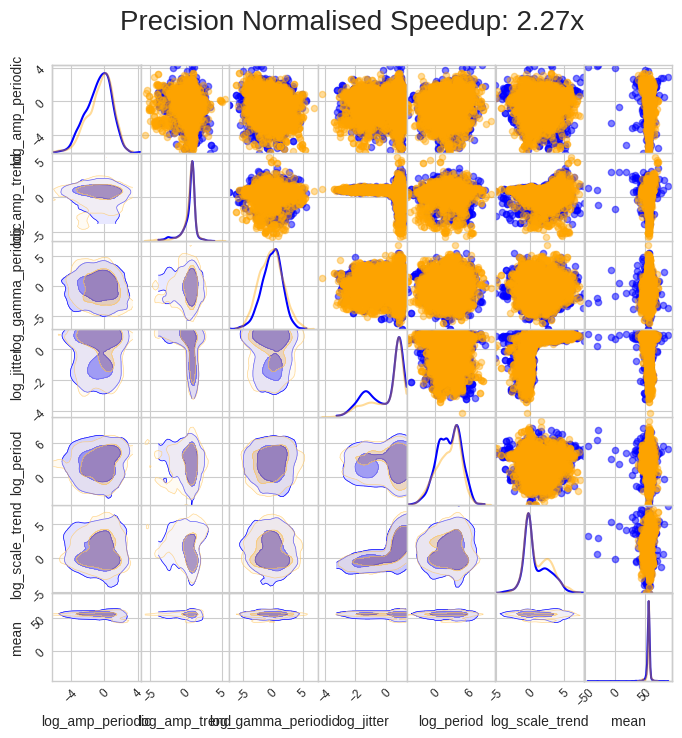

In [61]:

# --- 3. PLOTTING ---
# 1. Prepare clean labels (to fix the "None, labels" issue)
# Sometimes anesthetic picks up metadata from the columns. Let's ensure they are clean strings.
clean_param_names = [str(p) for p in param_names]

# Re-initialize samples with clean labels if needed, or just use strings in plot_2d
samples.labels = clean_param_names
samples_repart.labels = clean_param_names

# 2. Create axes with more space
# Use 'label_rotation=45' to prevent parameter names from crashing into each other
fig, axes = make_2d_axes(clean_param_names, upper=True, figsize=(8, 8))

# 3. Plotting (We pass legend=False to prevent the mess)
samples.compress().plot_2d(
    axes,
    c='blue',
    kind={'lower': 'kde_2d', 'diagonal': 'kde_1d', 'upper': 'scatter'},
    label='Baseline',
    legend=False
)

samples_repart.compress().plot_2d(
    axes,
    c='orange',
    kind={'lower': 'kde_2d', 'diagonal': 'kde_1d', 'upper': 'scatter'},
    label='Guided Posterior',
    alpha=0.4,
    legend=False
)




# --- 5. CLEANUP ---

# Add ONE single legend in the top right empty area
# Using fig.legend is often cleaner for these types of plots
handles, labels = axes.iloc[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize=14)

# Adjust spacing so labels don't overlap
plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.suptitle(f"Precision Normalised Speedup: {pns:.2f}x", fontsize=20, y=0.95)
plt.show()

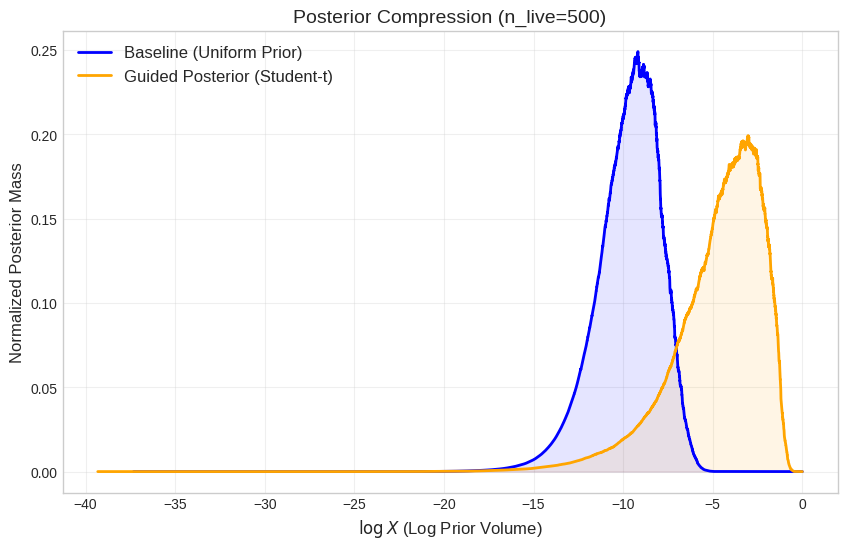

In [62]:
def get_posterior_mass_curve(samples, label, nlive_val):
    """
    Calculates logX and normalized Posterior Mass (L*X) / Z
    """
    # 1. Sort by logL (Critical for NS volume ordering)
    df = samples.copy().sort_values('logL')

    # 2. Use the EXPLICIT nlive passed from your script
    # (Do not rely on internal attributes which might be missing)

    # 3. Calculate logX correctly
    # Approximation: logX decreases by 1/nlive at every step
    N = len(df)
    logX = samples.logX().values

    # 4. Calculate log(Posterior Mass) = logL + logX
    log_mass = df['logL'].values + logX

    # 5. Normalize using the logZ calculated by the sampler
    # This prevents the 1e-49 scale issues
    logZ = samples.logZ() # Anesthetic helper to get evidence

    # Convert to probability density
    prob = np.exp(log_mass - logZ)


    return logX, prob

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# IMPORTANT: Pass the 'n_live' variable you defined in your configuration
# (e.g., if you set n_live = 1000 or 500 at the start of your script)

# 1. Baseline Curve
lx_base, p_base = get_posterior_mass_curve(samples, "Baseline", n_live)
plt.plot(lx_base, p_base, label='Baseline (Uniform Prior)', color='blue', linewidth=2)
plt.fill_between(lx_base, 0, p_base, color='blue', alpha=0.1)

# 2. Repartitioned Curve
lx_repart, p_repart = get_posterior_mass_curve(samples_repart, "Guided", n_live)
plt.plot(lx_repart, p_repart, label='Guided Posterior (Student-t)', color='orange', linewidth=2)
plt.fill_between(lx_repart, 0, p_repart, color='orange', alpha=0.1)

# Formatting
plt.xlabel(r'$\log X$ (Log Prior Volume)', fontsize=12)
plt.ylabel(r'Posterior Mass', fontsize=12)
plt.title(f'Posterior Compression (n_live={n_live})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)



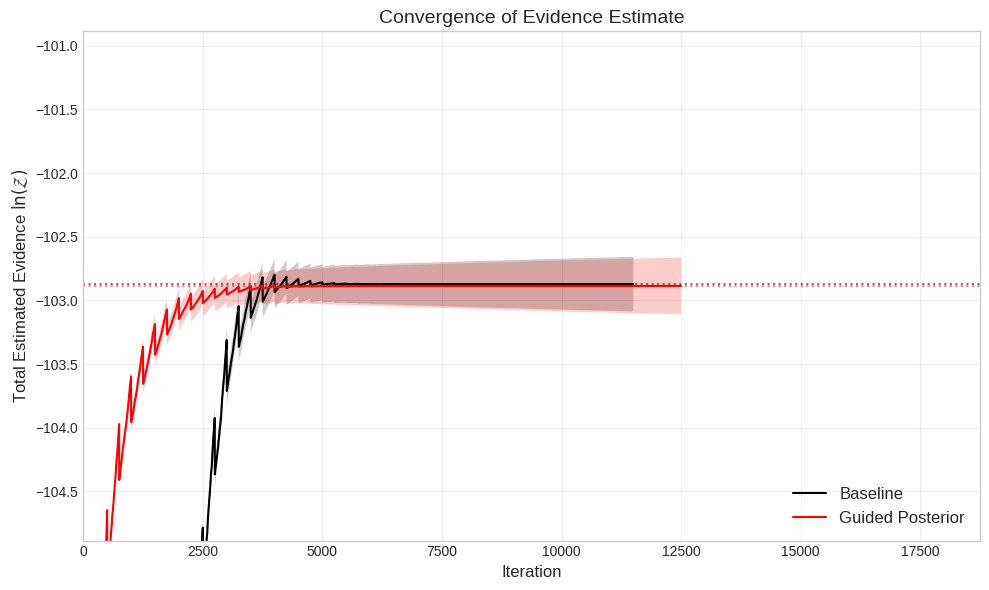

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_consistent_evidence(samples, label, color, nlive_approx=500):
    """
    Plots Total Evidence using consistent weights to avoid 'humps'.
    """
    # 1. Sort by logL
    df = samples.sort_values('logL').copy()

    # 2. Get rigorous weights from anesthetic
    # These contain the correct volume information automatically
    logw = df.logw(beta=1).values

    # 3. Accumulated Dead Evidence
    # Z_dead = sum(weights so far)
    logZ_dead = np.logaddexp.accumulate(logw)

    # 4. Estimated Live Evidence (The Fix)
    # Instead of manually calculating volume, we infer it from the weight.
    # Weight ~ (L * X) / Nlive  ->  L * X ~ Weight * Nlive
    # This ensures the Live estimate matches the scale of the Dead estimate.
    logZ_live = logw + np.log(nlive_approx)

    # 5. Total Evidence
    logZ_total = np.logaddexp(logZ_dead, logZ_live)

    # 6. Error Bars (Standard NS Error)
    # Sigma ~ sqrt(H / Nlive). We approximate H via iterations for plotting.
    iterations = np.arange(1, len(df) + 1)
    # Prevent divide by zero in first few steps
    safe_iters = np.maximum(iterations, 1.0)
    sigma = np.sqrt(safe_iters / nlive_approx) / np.sqrt(nlive_approx)

    # 7. Plotting
    plt.plot(iterations, logZ_total, label=label, color=color, linewidth=1.5)

    plt.fill_between(iterations,
                     logZ_total - sigma,
                     logZ_total + sigma,
                     color=color, alpha=0.2, edgecolor='none')

    return logZ_total[-1]

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# 1. Plot Baseline
final_z_base = plot_consistent_evidence(samples, "Baseline", "black", nlive_approx=500)

# 2. Plot Guided Posterior
final_z_repart = plot_consistent_evidence(samples_repart, "Guided Posterior", "red", nlive_approx=500)

# 3. Reference Lines (Final calculated value)
plt.axhline(final_z_base, color='black', linestyle=':', alpha=0.5)
plt.axhline(final_z_repart, color='red', linestyle=':', alpha=0.5)

# 4. Zoom in (Crucial)
# Focus on the stable region.
# We determine the limits based on the Guided run (Red) which converges first
target_val = final_z_repart
plt.ylim(target_val - 2, target_val + 2)

# Optional: Limit X axis to where the Red run finishes + some buffer
max_iter = len(samples_repart) * 1.5
plt.xlim(0, max_iter)

# --- FORMATTING ---
plt.xlabel("Iteration", fontsize=12)
plt.ylabel(r"Total Estimated Evidence $\ln(\mathcal{Z})$", fontsize=12)
plt.title("Convergence of Evidence Estimate", fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig("New_run.pdf")